# Model the time evolution of the Fried parameter $r_{0}$ in Pachon DIMM data

## jupyter boilerplate

Imports of python modules I usually want when working a a jupyter notebook.

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import sys
import os
from collections import namedtuple
from functools import partial
from datetime import datetime, timedelta
import calendar

import astropy
import astropy.coordinates
import astropy.units as u
from astropy.coordinates import EarthLocation, get_sun, AltAz
import psycopg2
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import healpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
pd.options.display.max_rows = 10

import statsmodels.graphics.tsaplots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tools.sm_exceptions import MissingDataError
from scipy.stats import anderson_ksamp
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.optimize import curve_fit
from statsmodels.formula.api import ols as formula_ols
from statsmodels.graphics.gofplots import qqplot
import cycler

mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')
np.random.seed(6563)
BLUE = "#004D99"
RED = "#AF2F2F"
mpl.rcParams["axes.prop_cycle"] = cycler.cycler(
    color=[
        "#002C8C",
        "#4C8C2C",
        "#AF2F2F",
        "#CC8C00",
        "#ABB200",
        "#A500D1",
        "#008498",
        "#00E800",
        "#9FA69C",
        "#01D5E7",
        "#7A5600",
    ]
)

In [2]:
note_dir = '../figures'
data_dir = '../data'

## Load the Pachon DIMM data

The data from the DIMM Pachon loaded here was provided to me by Edison Bustos in email on 2019-10-07. It contains time stamps and seeing estimates from Pachon DIMM data. These estimates arise from an equation that assumes Kolmogorov seeing, and are calculated for a wavelongth of 500nm. See equation 5 of Tokovinin 2002 (2002PASP..114.1156T).

### Read the raw data

The email included two separate files with diffirent date ranges. Read both and merge them.

In [3]:
raw_dimm = pd.read_hdf(os.path.join(data_dir, 'Pachon_DIMM_to_2019-10-07.h5'))
raw_dimm.head()

,time,hr,fwhm,flux,strehlL,strehlR,mjd,month,year,data_month,night,am,strehl,strehl_frac_diff,r0,log_r0,solar_zd
t,,,,,,,,,,,,,,,,,
2004-03-17 02:33:15+00:00,2004-03-17 02:33:15+00:00,4763,0.71,466228,0.0,0.0,53081.106424,3,2004,3,53081,False,0.0,NaN,0.142352,-0.846637,134.478719
2004-03-17 02:34:35+00:00,2004-03-17 02:34:35+00:00,4763,0.74,470195,0.0,0.0,53081.107350,3,2004,3,53081,False,0.0,NaN,0.136581,-0.864611,134.707136
2004-03-17 02:35:42+00:00,2004-03-17 02:35:42+00:00,4763,0.74,460268,0.0,0.0,53081.108125,3,2004,3,53081,False,0.0,NaN,0.136581,-0.864611,134.897625
2004-03-17 02:36:49+00:00,2004-03-17 02:36:49+00:00,4763,0.75,462758,0.0,0.0,53081.108900,3,2004,3,53081,False,0.0,NaN,0.134760,-0.870440,135.087365
2004-03-17 02:37:58+00:00,2004-03-17 02:37:58+00:00,4763,0.72,457338,0.0,0.0,53081.109699,3,2004,3,53081,False,0.0,NaN,0.140375,-0.852711,135.281977


### Filter out unreasonable values

In [4]:
raw_dimm['seeing'] = raw_dimm.fwhm
raw_dimm.query('(seeing < 5) & (seeing > 0.1)', inplace=True)

/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/core/generic.py:456: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/core/generic.py:464: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


Filter out values with bad Strehl ratios

In [5]:
def remove_bad_strehl_hours(dimm, min_strehl=0.25):
    df = pd.DataFrame({'strehl': 0.5*(dimm.strehlL + dimm.strehlR),
                       'mjd_hour': np.floor(dimm.mjd*24)/24})
    median_strehl_byhour = df.groupby('mjd_hour').median()
    
    df = df.reset_index().set_index('mjd_hour')
    df['hour_median_strehl'] = median_strehl_byhour
    df = df.reset_index().set_index('t')
    good_strehl = df.hour_median_strehl > min_strehl
    good_dimm = dimm.loc[good_strehl].copy()
    return good_dimm

In [6]:
raw_dimm = remove_bad_strehl_hours(raw_dimm)

In [7]:
raw_dimm.to_hdf(os.path.join(data_dir, 'Pachon_DIMM_to_2019-10-07_cut25.h5'), 'dimm')

### Calculate von Karman seeing

Tokovinin 2002 provides an equation (eqn 19) that approximates the seeing for a given Fried paramater assuming a von Karman model. This model requires an estime of the outer scale of the seeing, $L_0$. A value for $L_0$ is poorly known; the only estimate I can find is from Ziad et al 2000 (2000ApOpt..39.5415Z), which gives a value of 28.4 -13.3/+25.0 meters. I will use a value of 30 meters.

In [8]:
def calc_FWHM_vK(fwhm_dimm, outer_scale=30, wavelength=5.0e-7):
    r0 = 0.98*wavelength/(np.radians(fwhm_dimm/(60*60)))
    fwhm = fwhm_dimm * np.sqrt(1.0 - 2.183*np.power(r0/outer_scale, 0.356) )
    return fwhm

raw_dimm['vk_seeing'] = calc_FWHM_vK(raw_dimm.seeing, 30)

In [9]:
raw_dimm.describe()

,hr,fwhm,flux,strehlL,strehlR,mjd,month,year,data_month,night,strehl,strehl_frac_diff,r0,log_r0,solar_zd,seeing,vk_seeing
count,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06,1.320513e+06
mean,4.090894e+03,8.796361e-01,5.746648e+04,5.356205e-01,5.571079e-01,5.603099e+04,6.327251e+00,2.011801e+03,9.994089e+01,5.603080e+04,5.463642e-01,1.860714e-01,1.290031e-01,-9.132852e-01,1.294093e+02,8.796361e-01,7.373951e-01
std,2.543882e+03,3.392221e-01,6.507132e+04,1.566280e-01,1.314610e-01,1.708142e+03,3.557670e+00,4.696868e+00,5.612699e+01,1.708144e+03,1.327194e-01,1.742662e-01,4.271425e-02,1.471950e-01,1.751726e+01,3.392221e-01,3.079837e-01
min,9.900000e+01,1.010000e-01,4.750000e+02,7.000000e-02,6.600000e-02,5.313195e+04,1.000000e+00,2.004000e+03,5.000000e+00,5.313200e+04,6.800000e-02,0.000000e+00,2.022204e-02,-1.694175e+00,2.908286e+01,1.010000e-01,5.970229e-02
25%,2.294000e+03,6.600000e-01,2.394900e+04,4.200000e-01,4.680000e-01,5.449639e+04,3.000000e+00,2.008000e+03,4.900000e+01,5.449600e+04,4.510000e-01,5.864198e-02,1.000691e-01,-9.997002e-01,1.159380e+02,6.600000e-01,5.388234e-01
50%,3.699000e+03,8.100000e-01,4.385600e+04,5.670000e-01,5.780000e-01,5.595616e+04,6.000000e+00,2.012000e+03,9.700000e+01,5.595600e+04,5.690000e-01,1.278351e-01,1.247775e-01,-9.038638e-01,1.269534e+02,8.100000e-01,6.728152e-01
75%,5.288000e+03,1.010000e+00,6.120600e+04,6.500000e-01,6.620000e-01,5.761212e+04,9.000000e+00,2.016000e+03,1.520000e+02,5.761200e+04,6.520000e-01,2.639916e-01,1.531360e-01,-8.149227e-01,1.411981e+02,1.010000e+00,8.530649e-01
max,8.425000e+03,4.998000e+00,1.100932e+06,1.055000e+00,1.032000e+00,5.876340e+04,1.200000e+01,2.019000e+03,1.900000e+02,5.876300e+04,9.980000e-01,1.300699e+00,1.000691e+00,2.998394e-04,1.731993e+02,4.998000e+00,4.574718e+00


### Plot the time series

I'll start by just plotting the time series, averaged by month. 

I plot include a [lowess](https://en.wikipedia.org/wiki/Local_regression) smoothed curved through the points, which just estimates a smooth function by doing linear fits to nearby points.

/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff2b6d44ca0> has a label of '_no_label_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff2b6d071f0> has a label of '_no_label_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


Text(0, 0.5, 'FWHM (asec)')

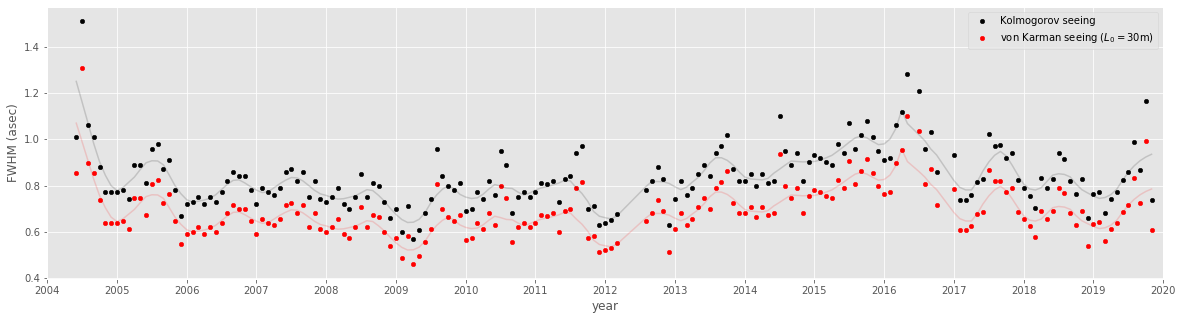

In [10]:
mpl.rcParams['figure.figsize'] = (20, 5)
fig, axes = plt.subplots()

df = raw_dimm.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median'}).reset_index()
df.plot.scatter('data_month', 'seeing', color='black', label='Kolmogorov seeing', ax=axes)
df.plot.scatter('data_month', 'vk_seeing', color='red', label='von Karman seeing ($L_0=30$m)', ax=axes)

df['seeing_lowess'] = lowess(df.seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'seeing_lowess', color='black', alpha=0.15, label='_no_label_', ax=axes)
df['vk_seeing_lowess'] = lowess(df.vk_seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'vk_seeing_lowess', color='red', alpha=0.15, label='_no_label_', ax=axes)

month_ticks = np.arange(0, 200, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(raw_dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('FWHM (asec)')

Make a similar plot for the Fried parameter:

/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff2b6b95a90> has a label of '_no_label_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


Text(0, 0.5, 'Fried parameter $r_0$ (meters)')

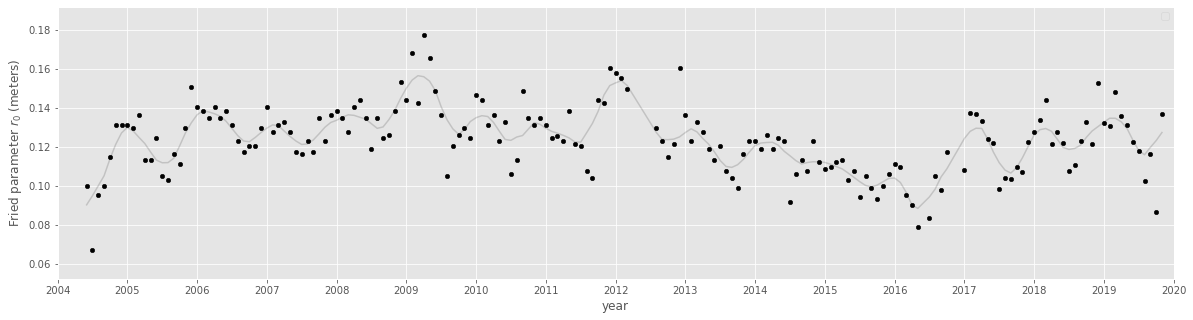

In [11]:
mpl.rcParams['figure.figsize'] = (20, 5)
fig, axes = plt.subplots()

df = raw_dimm.groupby('data_month').agg({'r0': 'median'}).reset_index()
df.plot.scatter('data_month', 'r0', color='black', ax=axes)

df['r0_lowess'] = lowess(df.r0, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'r0_lowess', color='black', alpha=0.15, label='_no_label_', ax=axes)

month_ticks = np.arange(0, 200, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(raw_dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('Fried parameter $r_0$ (meters)')

## Check the distributions

The time series modeling I indend to do works best with data that are normally distributed. Check the distribution of data we actually have.

In [12]:
raw_dimm.head()

,time,hr,fwhm,flux,strehlL,strehlR,mjd,month,year,data_month,night,am,strehl,strehl_frac_diff,r0,log_r0,solar_zd,seeing,vk_seeing
t,,,,,,,,,,,,,,,,,,,
2004-05-06 22:47:26+00:00,2004-05-06 22:47:26+00:00,4763,1.74,477495,0.382,0.386,53131.949606,5,2004,5,53132,False,0.3840,0.010417,0.058086,-1.235928,100.052186,1.74,1.520723
2004-05-06 22:48:36+00:00,2004-05-06 22:48:36+00:00,4763,1.40,478797,0.400,0.397,53131.950417,5,2004,5,53132,False,0.3985,0.007528,0.072193,-1.141507,100.297162,1.40,1.208253
2004-05-06 22:49:46+00:00,2004-05-06 22:49:46+00:00,4763,1.40,483239,0.395,0.405,53131.951227,5,2004,5,53132,False,0.4000,0.025000,0.072193,-1.141507,100.542278,1.40,1.208253
2004-05-06 22:50:56+00:00,2004-05-06 22:50:56+00:00,4763,1.35,472786,0.396,0.403,53131.952037,5,2004,5,53132,False,0.3995,0.017522,0.074866,-1.125713,100.787533,1.35,1.162498
2004-05-06 22:52:06+00:00,2004-05-06 22:52:06+00:00,4763,1.27,475489,0.384,0.403,53131.952847,5,2004,5,53132,False,0.3935,0.048285,0.079582,-1.099183,101.032924,1.27,1.089410


/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/core/generic.py:456: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/core/generic.py:464: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()
/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/core/generic.py:456: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s =

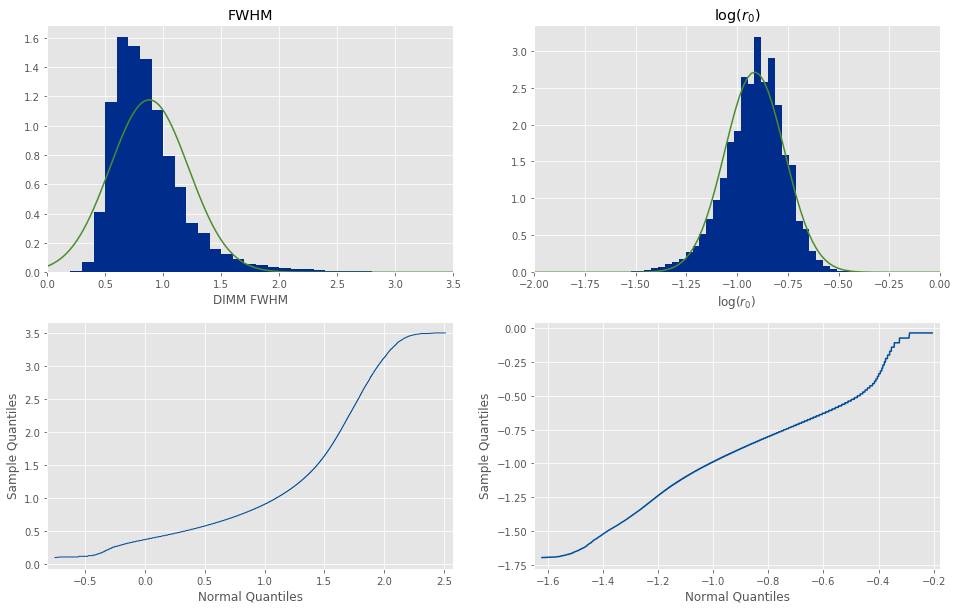

In [13]:
mpl.rcParams['figure.figsize'] = (16, 10)
fig, axes = plt.subplots(2,2)

axes[0,0].set_title('FWHM')
raw_dimm.fwhm.hist(bins=np.arange(0, 3.5, 0.1), density=True, ax=axes[0,0])
fwhm_norm_fit = scipy.stats.norm.fit(raw_dimm.fwhm)
x = np.linspace(0, 3.5, 500)
fwhm_fit = pd.DataFrame({'x': x,
                         'fwhm': scipy.stats.norm.pdf(x, loc=fwhm_norm_fit[0], scale=fwhm_norm_fit[1])})
fwhm_fit.plot('x', 'fwhm', ax=axes[0,0], label='best fit')

qqplot(raw_dimm.query('fwhm>0 and fwhm<3.5').fwhm, color=BLUE, linewidth=1, loc=fwhm_norm_fit[0], scale=fwhm_norm_fit[1], ax=axes[1,0])

axes[0,1].set_title('$\log(r_{0})$')
raw_dimm.log_r0.hist(bins=50, density=True, ax=axes[0,1])

lr0_norm_fit = scipy.stats.norm.fit(raw_dimm.log_r0)
x = np.linspace(-2, 0, 100)
lr0_fit = pd.DataFrame({'x': x,
                       'lr0': scipy.stats.norm.pdf(x, loc=lr0_norm_fit[0], scale=lr0_norm_fit[1])})
lr0_fit.plot('x', 'lr0', ax=axes[0,1])

axes[0,0].set_xlabel('DIMM FWHM')
axes[0,0].get_legend().remove()
axes[0,1].set_xlabel('$\log(r_{0})$')
axes[0,1].get_legend().remove()
axes[1,1].set_title("")
axes[1,0].set_title("")

#scipy.stats.probplot(raw_dimm.log_r0, dist=scipy.stats.norm, plot=axes[1,1])
qqplot(raw_dimm.query('r0>0 and r0<1').log_r0, color=BLUE, loc=lr0_norm_fit[0], scale=lr0_norm_fit[1], ax=axes[1, 1])

# axes[1, 1].get_lines()[0].set_markersize(1)
for ax in axes[1, :]:
    ax.get_lines()[0].set_marker("")
    ax.get_lines()[0].set_linestyle("-")
    ax.set_xlabel('Normal Quantiles')
    
fig.savefig(os.path.join(note_dir, 'r0_dist.png'), pdi=300, bbox_inches='tight')

In [14]:
scipy.stats.normaltest(raw_dimm.r0), scipy.stats.normaltest(raw_dimm.log_r0)

(NormaltestResult(statistic=382184.25822166924, pvalue=0.0),
 NormaltestResult(statistic=58970.787378846166, pvalue=0.0))

In [15]:
df = raw_dimm.sample(1000)
scipy.stats.normaltest(df.r0), scipy.stats.normaltest(df.log_r0)

(NormaltestResult(statistic=181.93065147345203, pvalue=3.1207644350212757e-40),
 NormaltestResult(statistic=30.92686639427761, pvalue=1.9244928025332835e-07))

Okay, neither are really Gaussian, but $\log(r_{0})$ is closer to normal than $r_{0}$. One notable feature is the low-value tail of $log(r_0)$. This suggests that there is a poor-seeing tail of the distribution that my model will not be able to model well.

## Remove suspicious early data

In [16]:
good_dimm = raw_dimm.query('mjd > 53538').copy()
good_dimm['time'].min()

/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/core/generic.py:456: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/core/generic.py:464: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


Timestamp('2005-06-17 00:23:31+0000', tz='UTC')

## Resample on 5 minute intervals

In [17]:
resampled_time_index = pd.date_range(good_dimm.index.min().floor('5Min'), good_dimm.index.max().ceil('5Min'), freq='5Min')
dimm = pd.DataFrame(good_dimm.reindex(resampled_time_index, method='nearest', limit=1, tolerance='150Sec'))
dimm.index.rename('time', inplace=True)
dimm

/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/core/indexes/base.py:3071: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


,time,hr,fwhm,flux,strehlL,strehlR,mjd,month,year,data_month,night,am,strehl,strehl_frac_diff,r0,log_r0,solar_zd,seeing,vk_seeing
time,,,,,,,,,,,,,,,,,,,
2005-06-17 00:20:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-17 00:25:00+00:00,2005-06-17 00:24:43+00:00,5132.0,0.870,38987.0,0.298,0.355,53538.017164,6.0,2005.0,18.0,53538.0,False,0.3265,0.174579,0.116172,-0.934898,122.546896,0.870,0.726720
2005-06-17 00:30:00+00:00,2005-06-17 00:29:28+00:00,5132.0,0.950,39125.0,0.284,0.332,53538.020463,6.0,2005.0,18.0,53538.0,False,0.3080,0.155844,0.106389,-0.973102,123.557961,0.950,0.798827
2005-06-17 00:35:00+00:00,2005-06-17 00:35:33+00:00,5132.0,1.000,39470.0,0.295,0.348,53538.024688,6.0,2005.0,18.0,53538.0,False,0.3215,0.164852,0.101070,-0.995379,124.854914,1.000,0.844016
2005-06-17 00:40:00+00:00,2005-06-17 00:40:20+00:00,5132.0,0.780,39145.0,0.317,0.364,53538.028009,6.0,2005.0,18.0,53538.0,False,0.3405,0.138032,0.129577,-0.887473,125.876263,0.780,0.645924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-07 09:15:00+00:00,2019-10-07 09:15:20+00:00,2294.0,0.540,16249.0,0.301,0.518,58763.385648,10.0,2019.0,190.0,58763.0,True,0.4095,0.529915,0.187166,-0.727773,103.331128,0.540,0.432611
2019-10-07 09:20:00+00:00,2019-10-07 09:19:32+00:00,2294.0,0.509,16444.0,0.298,0.507,58763.388565,10.0,2019.0,190.0,58763.0,True,0.4025,0.519255,0.198565,-0.702097,102.451166,0.509,0.405348
2019-10-07 09:25:00+00:00,2019-10-07 09:24:54+00:00,2294.0,0.527,16497.0,0.310,0.512,58763.392292,10.0,2019.0,190.0,58763.0,True,0.4110,0.491484,0.191783,-0.717189,101.323585,0.527,0.421169


## Simple new columns

In [18]:
resampled_times = pd.Series(dimm.index, index=dimm.index)
dimm['yday'] = resampled_times.apply(lambda t: t.timetuple().tm_yday)

In [19]:
dimm.head()

,time,hr,fwhm,flux,strehlL,strehlR,mjd,month,year,data_month,night,am,strehl,strehl_frac_diff,r0,log_r0,solar_zd,seeing,vk_seeing,yday
time,,,,,,,,,,,,,,,,,,,,
2005-06-17 00:20:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168
2005-06-17 00:25:00+00:00,2005-06-17 00:24:43+00:00,5132.0,0.87,38987.0,0.298,0.355,53538.017164,6.0,2005.0,18.0,53538.0,False,0.3265,0.174579,0.116172,-0.934898,122.546896,0.87,0.726720,168
2005-06-17 00:30:00+00:00,2005-06-17 00:29:28+00:00,5132.0,0.95,39125.0,0.284,0.332,53538.020463,6.0,2005.0,18.0,53538.0,False,0.3080,0.155844,0.106389,-0.973102,123.557961,0.95,0.798827,168
2005-06-17 00:35:00+00:00,2005-06-17 00:35:33+00:00,5132.0,1.00,39470.0,0.295,0.348,53538.024688,6.0,2005.0,18.0,53538.0,False,0.3215,0.164852,0.101070,-0.995379,124.854914,1.00,0.844016,168
2005-06-17 00:40:00+00:00,2005-06-17 00:40:20+00:00,5132.0,0.78,39145.0,0.317,0.364,53538.028009,6.0,2005.0,18.0,53538.0,False,0.3405,0.138032,0.129577,-0.887473,125.876263,0.78,0.645924,168


In [20]:
dimm.describe().T

,count,mean,std,min,25%,50%,75%,max
hr,297663.0,4055.189829,2539.587087,99.000000,2294.000000,3699.000000,5288.000000,8.425000e+03
fwhm,297663.0,0.875137,0.338973,0.101000,0.656000,0.804000,1.010000,4.948000e+00
flux,297663.0,51161.929420,47180.129357,587.000000,24058.000000,43306.000000,59081.000000,1.099457e+06
strehlL,297663.0,0.549882,0.148749,0.098000,0.452000,0.580000,0.654000,1.055000e+00
strehlR,297663.0,0.567843,0.126272,0.127000,0.485000,0.589000,0.667000,1.016000e+00
...,...,...,...,...,...,...,...,...
log_r0,297663.0,-0.910840,0.147870,-1.689808,-0.999700,-0.900635,-0.812283,2.998394e-04
solar_zd,297663.0,129.120264,17.494377,29.082861,115.681472,126.747729,140.779270,1.731983e+02
seeing,297663.0,0.875137,0.338973,0.101000,0.656000,0.804000,1.010000,4.948000e+00
vk_seeing,297663.0,0.733355,0.307718,0.059702,0.535267,0.667434,0.853065,4.527380e+00


## Flag twilight values

In [21]:
dimm['twilight'] = dimm.solar_zd < 108.0
dimm['twilight24'] = dimm.solar_zd < 114.0

## Take a look at the result

In [22]:
dimm.head()

,time,hr,fwhm,flux,strehlL,strehlR,mjd,month,year,data_month,...,strehl,strehl_frac_diff,r0,log_r0,solar_zd,seeing,vk_seeing,yday,twilight,twilight24
time,,,,,,,,,,,,,,,,,,,,,
2005-06-17 00:20:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168,False,False
2005-06-17 00:25:00+00:00,2005-06-17 00:24:43+00:00,5132.0,0.87,38987.0,0.298,0.355,53538.017164,6.0,2005.0,18.0,...,0.3265,0.174579,0.116172,-0.934898,122.546896,0.87,0.726720,168,False,False
2005-06-17 00:30:00+00:00,2005-06-17 00:29:28+00:00,5132.0,0.95,39125.0,0.284,0.332,53538.020463,6.0,2005.0,18.0,...,0.3080,0.155844,0.106389,-0.973102,123.557961,0.95,0.798827,168,False,False
2005-06-17 00:35:00+00:00,2005-06-17 00:35:33+00:00,5132.0,1.00,39470.0,0.295,0.348,53538.024688,6.0,2005.0,18.0,...,0.3215,0.164852,0.101070,-0.995379,124.854914,1.00,0.844016,168,False,False
2005-06-17 00:40:00+00:00,2005-06-17 00:40:20+00:00,5132.0,0.78,39145.0,0.317,0.364,53538.028009,6.0,2005.0,18.0,...,0.3405,0.138032,0.129577,-0.887473,125.876263,0.78,0.645924,168,False,False


In [23]:
dimm.describe()

,hr,fwhm,flux,strehlL,strehlR,mjd,month,year,data_month,night,strehl,strehl_frac_diff,r0,log_r0,solar_zd,seeing,vk_seeing,yday
count,297663.000000,297663.000000,2.976630e+05,297663.000000,297663.000000,297663.000000,297663.000000,297663.000000,297663.000000,297663.000000,297663.000000,297663.000000,297663.000000,297663.000000,297663.000000,297663.000000,297663.000000,1.504912e+06
mean,4055.189829,0.875137,5.116193e+04,0.549882,0.567843,56082.411825,6.359238,2011.939012,101.627377,56082.216772,0.558862,0.177501,0.129814,-0.910840,129.120264,0.875137,0.733355,1.839807e+02
std,2539.587087,0.338973,4.718013e+04,0.148749,0.126272,1616.442758,3.586547,4.449774,53.118043,1616.444375,0.126019,0.163204,0.043490,0.147870,17.494377,0.338973,0.307718,1.045629e+02
min,99.000000,0.101000,5.870000e+02,0.098000,0.127000,53538.017164,1.000000,2005.000000,18.000000,53538.000000,0.160000,0.000000,0.020426,-1.689808,29.082861,0.101000,0.059702,1.000000e+00
25%,2294.000000,0.656000,2.405800e+04,0.452000,0.485000,54592.171667,3.000000,2008.000000,53.000000,54592.000000,0.469500,0.056864,0.100069,-0.999700,115.681472,0.656000,0.535267,9.400000e+01
50%,3699.000000,0.804000,4.330600e+04,0.580000,0.589000,55952.284780,6.000000,2012.000000,97.000000,55952.000000,0.582500,0.122241,0.125709,-0.900635,126.747729,0.804000,0.667434,1.860000e+02
75%,5288.000000,1.010000,5.908100e+04,0.654000,0.667000,57471.397616,10.000000,2016.000000,147.000000,57471.000000,0.656000,0.253165,0.154070,-0.812283,140.779270,1.010000,0.853065,2.730000e+02
max,8425.000000,4.948000,1.099457e+06,1.055000,1.016000,58763.395949,12.000000,2019.000000,190.000000,58763.000000,0.998000,1.122507,1.000691,0.000300,173.198313,4.948000,4.527380,3.660000e+02


/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff2b6c2d1c0> has a label of '_no_label_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff2b50310a0> has a label of '_no_label_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


Text(0, 0.5, 'FWHM (asec)')

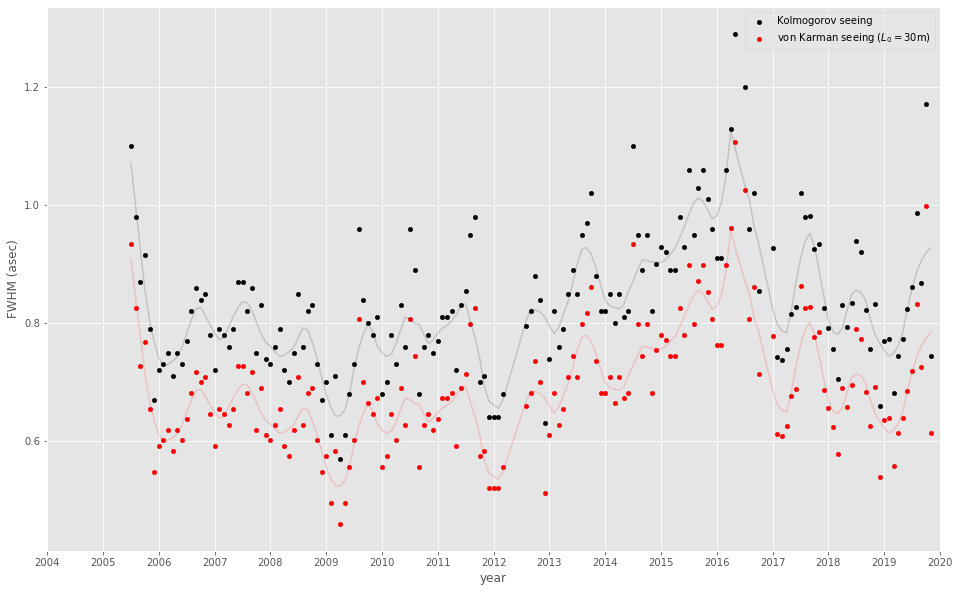

In [24]:
fig, axes = plt.subplots()

df = dimm.groupby('data_month').agg({'seeing': 'median', 'vk_seeing': 'median'}).reset_index()
df.plot.scatter('data_month', 'seeing', color='black', label='Kolmogorov seeing', ax=axes)
df.plot.scatter('data_month', 'vk_seeing', color='red', label='von Karman seeing ($L_0=30$m)', ax=axes)

df['seeing_lowess'] = lowess(df.seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'seeing_lowess', color='black', alpha=0.15, label='_no_label_', ax=axes)
df['vk_seeing_lowess'] = lowess(df.vk_seeing, df.data_month, frac=0.05).T[1]
df.plot('data_month', 'vk_seeing_lowess', color='red', alpha=0.15, label='_no_label_', ax=axes)

month_ticks = np.arange(0, 200, 12)
axes.set_xticks(month_ticks)
axes.set_xticklabels(np.min(raw_dimm.year) + (month_ticks/12).astype(int))
axes.set_xlabel('year')
axes.set_ylabel('FWHM (asec)')

## Variation by time of night

Note that a difference in $\ln(r_{0})$ corresponds to a ratio of $r_{0}$.

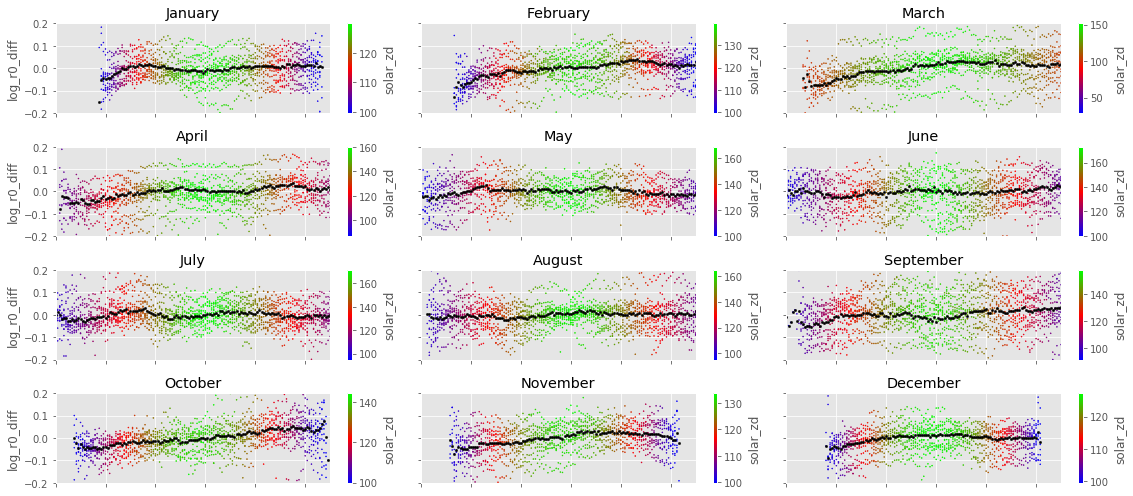

In [25]:
site_longitude_deg = EarthLocation.of_site('Cerro Pachon').lon.deg
site_night_shift = (180.0 + site_longitude_deg)/360.0

mpl.rcParams['figure.figsize'] = (16, 7)
fig, axes = plt.subplots(4,3)
for i, (m, df) in enumerate(dimm.groupby('month')):
    df = df.copy()
    df['t'] = np.floor((dimm.mjd + site_night_shift - np.floor(dimm.mjd + site_night_shift))*24*12)/12
    df['log_r0_diff'] = df.log_r0 - np.mean(df.log_r0)
    c = int(i % 3)
    r = int(i / 3)
    df.groupby(['year', 't'])['log_r0_diff', 'solar_zd'].mean().reset_index().plot.scatter('t', 'log_r0_diff', c='solar_zd', s=1, ylim=(-0.2, 0.2), xlim=(6, 17), sharex=True, sharey=True, ax=axes[r, c], cmap='brg')
    df.groupby(['t'])['log_r0_diff', 'solar_zd'].mean().reset_index().plot.scatter('t', 'log_r0_diff', s=5, c='black', ax=axes[r, c])
    axes[r, c].set_title(calendar.month_name[i+1])
    
plt.tight_layout()

It does look it me like there is something going on at the beginnings of nights is some but not all months, but the scatter is large. For the moment, I will not attempt to model this, but it will go in the to-do list for future improvements.

# Global averages by month

Now, I will take a look at seasonal variations by looking at the distributions by month.

In the boxplots below, the central blue line shows the median of the mothly medians of the data, and the box show the central two quaritles. The whiskers show the full range of the data, excluding outliers.

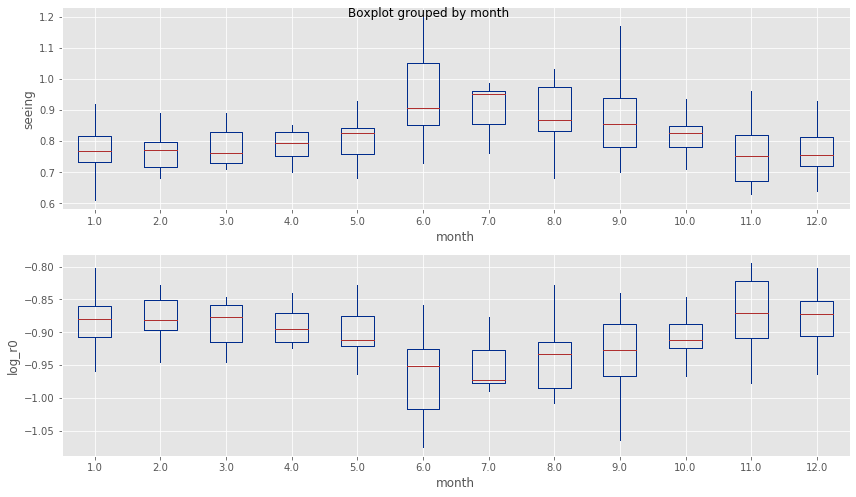

In [26]:
mpl.rcParams['figure.figsize'] = (12, 7)
fig, axes = plt.subplots(2)
dimm.groupby('data_month').median().boxplot('log_r0', 'month', showfliers=False, showcaps=False, ax=axes[1])
dimm.groupby('data_month').median().boxplot('seeing', 'month', showfliers=False, showcaps=False, ax=axes[0])

# Label the data on the y axis, not the top
for ax in axes:
    ax.set_ylabel(ax.get_title())
    ax.set_title('')

plt.tight_layout()

The seeing is obviously worse in June, July and August than in December, January, and February.

# Global mean by day of year

I also take a look at variation by day of the year.

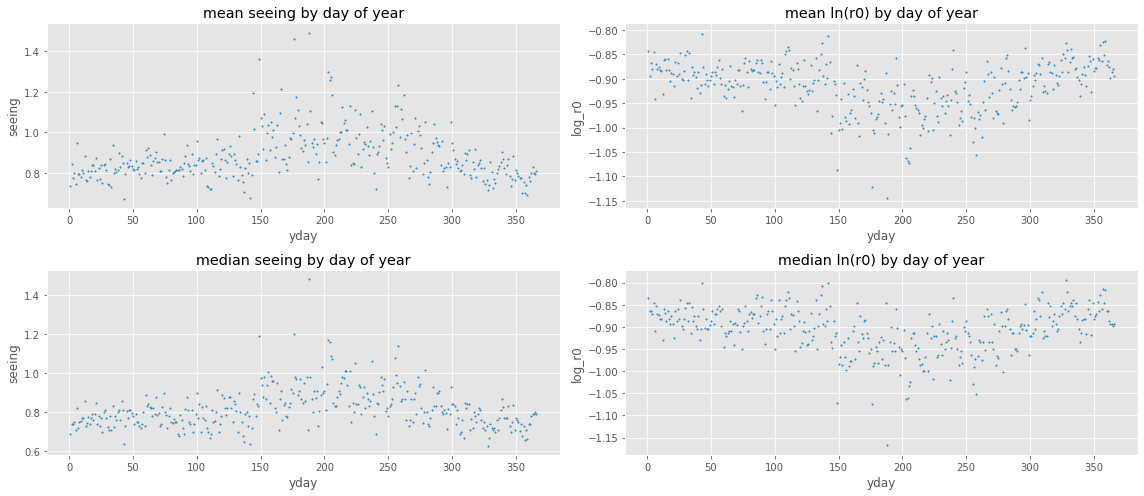

In [27]:
mpl.rcParams['figure.figsize'] = (16, 7)
fig, axes = plt.subplots(2, 2)
axes[0,0].set_title('mean seeing by day of year')
dimm.groupby(['yday'])['seeing'].mean().reset_index().plot.scatter('yday', 'seeing', s=2, ax=axes[0,0])
axes[0,1].set_title('mean ln(r0) by day of year')
dimm.groupby(['yday'])['log_r0'].mean().reset_index().plot.scatter('yday', 'log_r0', s=2, ax=axes[0,1])
axes[1,0].set_title('median seeing by day of year')
dimm.groupby(['yday'])['seeing'].median().reset_index().plot.scatter('yday', 'seeing', s=2, ax=axes[1,0])
axes[1,1].set_title('median ln(r0) by day of year')
dimm.groupby(['yday'])['log_r0'].median().reset_index().plot.scatter('yday', 'log_r0', s=2, ax=axes[1,1])
plt.tight_layout()

# Autocorrelation function of the nightly mean

Finally, the autocorrelation function shows a clearly oscillating long term correlation.

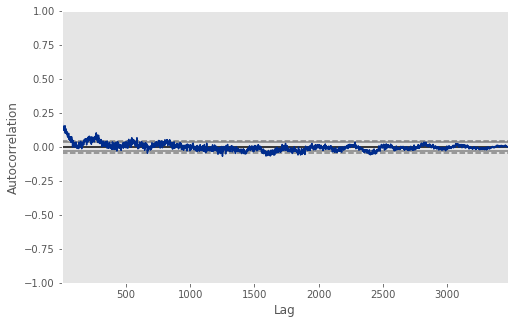

In [28]:
mpl.rcParams['figure.figsize'] = (8, 5)
df = dimm.groupby('night')['log_r0'].mean().reset_index().copy()
df.log_r0.fillna(method='ffill', inplace=True)
pd.plotting.autocorrelation_plot(df.log_r0)

# Fitting the yearly variation to a sine

While clearly present, the scatter in the data is large enough that complex models seem unwarranted; I will start with a simple sine, fit to the data using simple linear regress and the harmonic addition theorem.

In [29]:
df = dimm.query('~ twilight24').copy()
#df = dimm.copy()
df['cos'] = np.cos(df.mjd*2*np.pi/365.24217)
df['sin'] = np.sin(df.mjd*2*np.pi/365.24217)
trig_fit = formula_ols('log_r0 ~ cos + sin', data=df).fit()
trig_fit.summary()

/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/core/generic.py:456: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/data/des91.b/data/neilsen/anaconda/envs/ehn38_91/lib/python3.8/site-packages/pandas/core/generic.py:464: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_r0   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     5425.
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:14:20   Log-Likelihood:             1.2036e+05
No. Observations:              232349   AIC:                        -2.407e+05
Df Residuals:                  232346   BIC:                        -2.407e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9119      0.000  -3037.842      0.000      -0.913      -0.911
cos            0.0172      0.000     39.945      0.000       0.016       0.018
sin            0.0409      0.000     97.654      0.000       0.040       0.042
==============================================================================
Omnibus:                     8137.786   Durbin-Watson:                   0.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11420.370
Skew:                          -0.365   Prob(JB):                         0.00
Kurtosis:                       3.803   Cond. No.                         1.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
df.describe()

,hr,fwhm,flux,strehlL,strehlR,mjd,month,year,data_month,night,strehl,strehl_frac_diff,r0,log_r0,solar_zd,seeing,vk_seeing,yday,cos,sin
count,232349.000000,232349.000000,2.323490e+05,232349.000000,232349.000000,232349.000000,232349.000000,232349.000000,232349.000000,232349.000000,232349.000000,232349.000000,232349.000000,232349.000000,232349.000000,232349.000000,232349.000000,1.439598e+06,232349.000000,232349.000000
mean,4168.544177,0.873105,5.044356e+04,0.551464,0.569952,56068.690734,6.306793,2011.905973,101.178473,56068.497183,0.560708,0.178370,0.130031,-0.909978,135.235678,0.873105,0.731512,1.839892e+02,-0.025198,0.058235
std,2525.518286,0.336977,4.514334e+04,0.147591,0.124875,1618.222873,3.469848,4.452956,53.176829,1618.223098,0.124489,0.163712,0.043356,0.147469,14.721530,0.336977,0.305854,1.037213e+02,0.696605,0.714646
min,99.000000,0.101000,5.870000e+02,0.098000,0.158000,53538.017164,1.000000,2005.000000,18.000000,53538.000000,0.160000,0.000000,0.021220,-1.673259,114.000143,0.101000,0.059702,1.000000e+00,-1.000000,-1.000000
25%,2294.000000,0.653000,2.413100e+04,0.455000,0.489000,54580.371308,3.000000,2008.000000,52.000000,54580.000000,0.472500,0.057348,0.100969,-0.995813,123.759264,0.653000,0.532601,9.500000e+01,-0.704788,-0.678096
50%,3699.000000,0.800000,4.332900e+04,0.581000,0.590000,55945.173970,6.000000,2012.000000,97.000000,55945.000000,0.584000,0.122807,0.126337,-0.898469,131.590842,0.800000,0.663847,1.860000e+02,-0.073156,0.155650
75%,5288.000000,1.001000,5.909400e+04,0.655000,0.668000,57454.350451,9.000000,2016.000000,147.000000,57454.000000,0.656500,0.254144,0.154778,-0.810292,145.391809,1.001000,0.844921,2.720000e+02,0.667785,0.762466
max,8425.000000,4.763000,1.091870e+06,1.052000,1.016000,58763.347014,12.000000,2019.000000,190.000000,58763.000000,0.926000,1.122507,1.000691,0.000300,173.198313,4.763000,4.352316,3.660000e+02,1.000000,1.000000


In [31]:
df = dimm.copy()
df['cos'] = np.cos(df.mjd*2*np.pi/365.24217)
df['sin'] = np.sin(df.mjd*2*np.pi/365.24217)
dimm['fit_log_r0'] = trig_fit.params.Intercept + trig_fit.params.cos*df.cos + trig_fit.params.sin*df.sin
dimm['fit_r0'] = np.power(10, dimm.fit_log_r0)
dimm['fit_seeing'] = np.degrees(0.98*5e-7/dimm.fit_r0)*60*60
dimm['log_r0_fit_diff'] = dimm.log_r0 - dimm.fit_log_r0
dimm['fit_seeing_ratio'] = dimm.seeing/dimm.fit_seeing

In [32]:
def harmonic_addition(a, b):
    c = np.sqrt(a**2 + b**2)
    d = np.arctan2(-1*b, a)
    return c, d

harmonic_addition(trig_fit.params.cos, trig_fit.params.sin)

(0.04434634940210188, -1.1734693905525988)

In [33]:
def test_harmonic_addition(a, b, s=7):
    df = pd.DataFrame({'x': np.pi*np.random.uniform(0,2,7)})
    df['cos_sin'] = a*np.cos(df.x) + b*np.sin(df.x)
    c, d = harmonic_addition(a, b)
    df['cos_delta'] = c*np.cos(df.x+d)
    maxdiff = np.abs(df.cos_sin-df.cos_delta).max()
    assert maxdiff < np.abs(max([a, b]))*1.0e-10
    assert maxdiff < np.abs(c).max()*1.0e-10
    return maxdiff

test_harmonic_addition(trig_fit.params.cos, trig_fit.params.sin, s=7)

6.938893903907228e-18

Awesome. Harmonic addition works.

Now, derive more intuitive properties from our fit:

In [34]:
mean_log_r0 = trig_fit.params.Intercept
mean_seeing = np.degrees(0.98*5e-7/np.power(10, mean_log_r0))*60*60
seasonal_amplitude, seasonal_phase_radians = harmonic_addition(trig_fit.params.cos, trig_fit.params.sin)
seasonal_phase_days = 365.24217 + (seasonal_phase_radians * 365.24217 / (2 * np.pi))
best_mjd_day = 365.24217-seasonal_phase_days
best_datetime = datetime(1858, 11, 17) + timedelta(best_mjd_day)
worst_mjd_day = 365.24217-seasonal_phase_days-(365.24259/2)
worst_datetime = datetime(1858, 11, 17) + timedelta(worst_mjd_day)

best_seeing = np.degrees(0.98*5e-7/np.power(10, mean_log_r0+seasonal_amplitude))*60*60
worst_seeing = np.degrees(0.98*5e-7/np.power(10, mean_log_r0-seasonal_amplitude))*60*60

doy_phase_days = (365.24217 - seasonal_phase_days - 45) % 365.24217
best_doy_datetime = datetime(2020, 1, 1) + timedelta(doy_phase_days)
worst_doy_datetime = datetime(2020, 1, 1) + timedelta(doy_phase_days-(365.24259/2))

print("Mean Kolmogorov seeing: ", mean_seeing)
print("Amplitude of seasonal variation in log10(r0): ", seasonal_amplitude)
print("Phase of seasonal variation (calendar year): ", doy_phase_days)
print("    best seeing day of year: ", best_doy_datetime.strftime("%B %d"), '(', best_seeing, '")')
print("   worst seeing day of year: ", worst_doy_datetime.strftime("%B %d"), '(', worst_seeing, '")')

Mean Kolmogorov seeing:  0.825179757964612
Amplitude of seasonal variation in log10(r0):  0.04434634940210188
Phase of seasonal variation (calendar year):  23.213889242493167
    best seeing day of year:  January 24 ( 0.7450788174215923 ")
   worst seeing day of year:  July 25 ( 0.9138920836736735 ")


The seeing is worst at the end of July, and best at the end of January.

In [35]:
best_mjd_day

68.21388924249317

# Seeing and log(r0) with fit by day

Now, I take a look at whether my fit passes through the data, first on a nightly basis:

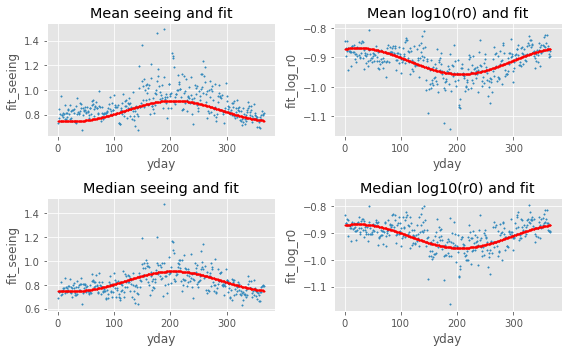

In [36]:
mpl.rcParams['figure.figsize'] = (8, 5)
fig, axes = plt.subplots(2, 2)
axes[0,0].set_title('Mean seeing and fit')
dimm.groupby(['yday'])['seeing'].mean().reset_index().plot.scatter('yday', 'seeing', s=2, ax=axes[0,0])
axes[0,1].set_title('Mean log10(r0) and fit')
dimm.groupby(['yday'])['log_r0'].mean().reset_index().plot.scatter('yday', 'log_r0', s=2, ax=axes[0,1])
axes[1,0].set_title('Median seeing and fit')
dimm.groupby(['yday'])['seeing'].median().reset_index().plot.scatter('yday', 'seeing', s=2, ax=axes[1,0])
axes[1,1].set_title('Median log10(r0) and fit')
dimm.groupby(['yday'])['log_r0'].median().reset_index().plot.scatter('yday', 'log_r0', s=2, ax=axes[1,1])

dimm.groupby(['yday'])['fit_seeing'].mean().reset_index().plot.scatter('yday', 'fit_seeing', s=2, c='r', ax=axes[0,0])
dimm.groupby(['yday'])['fit_log_r0'].mean().reset_index().plot.scatter('yday', 'fit_log_r0', s=2, c='r', ax=axes[0,1])
dimm.groupby(['yday'])['fit_seeing'].median().reset_index().plot.scatter('yday', 'fit_seeing', s=2, c='r', ax=axes[1,0])
dimm.groupby(['yday'])['fit_log_r0'].median().reset_index().plot.scatter('yday', 'fit_log_r0', s=2, c='r', ax=axes[1,1])

plt.tight_layout()

and also on a monthly one:

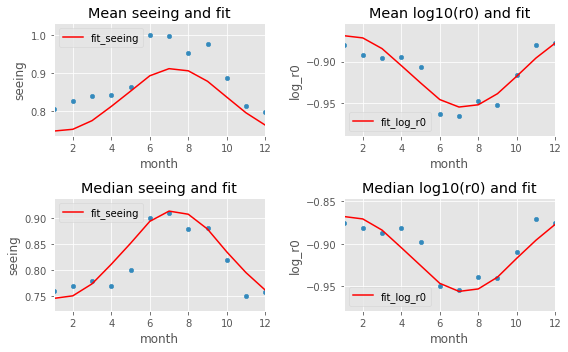

In [37]:
fig, axes = plt.subplots(2, 2)
axes[0,0].set_title('Mean seeing and fit')
dimm.groupby(['month'])['seeing'].mean().reset_index().plot.scatter('month', 'seeing', ax=axes[0,0])
axes[0,1].set_title('Mean log10(r0) and fit')
dimm.groupby(['month'])['log_r0'].mean().reset_index().plot.scatter('month', 'log_r0', ax=axes[0,1])
axes[1,0].set_title('Median seeing and fit')
dimm.groupby(['month'])['seeing'].median().reset_index().plot.scatter('month', 'seeing', ax=axes[1,0])
axes[1,1].set_title('Median log10(r0) and fit')
dimm.groupby(['month'])['log_r0'].median().reset_index().plot.scatter('month', 'log_r0', ax=axes[1,1])

dimm.groupby(['month'])['fit_seeing'].mean().reset_index().plot('month', 'fit_seeing', c='r', ax=axes[0,0])
dimm.groupby(['month'])['fit_log_r0'].mean().reset_index().plot('month', 'fit_log_r0', c='r', ax=axes[0,1])
dimm.groupby(['month'])['fit_seeing'].median().reset_index().plot('month', 'fit_seeing', c='r', ax=axes[1,0])
dimm.groupby(['month'])['fit_log_r0'].median().reset_index().plot('month', 'fit_log_r0', c='r', ax=axes[1,1])

plt.tight_layout()

# Seeing and log(r0) with fit by month

Now I check to see if subtraction of the model removes the obvious seasonal periodicity, first by day of year:

Text(0, 0.5, 'log10(r0) - fit log10(r0)')

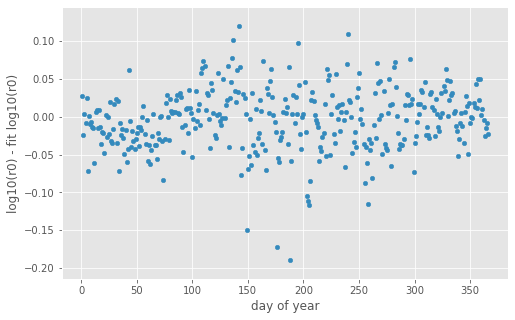

In [38]:
fig, axes = plt.subplots()
dimm.groupby('yday')['log_r0_fit_diff'].mean().reset_index().plot.scatter('yday', 'log_r0_fit_diff', ax=axes)
axes.set_xlabel('day of year')
axes.set_ylabel('log10(r0) - fit log10(r0)')

and then using monthly distributions:

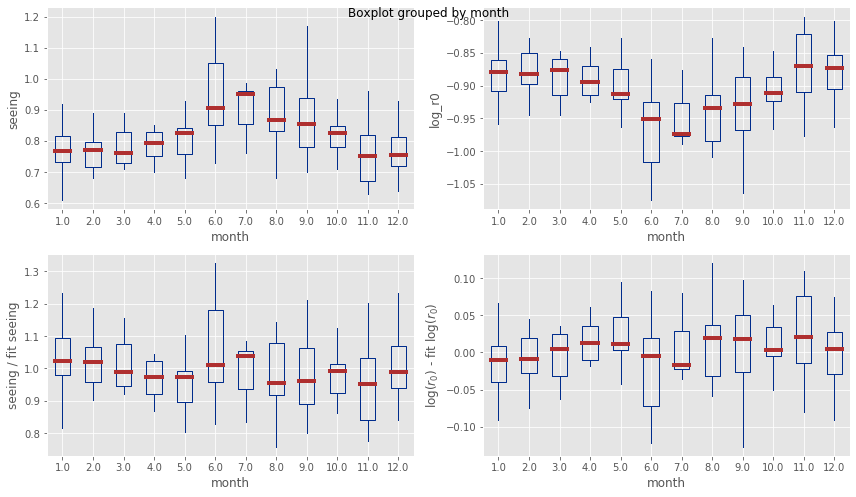

In [39]:
mpl.rcParams['figure.figsize'] = (12, 7)
fig, axes = plt.subplots(2,2)
dimm.groupby('data_month').median().boxplot('log_r0', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[0, 1])
dimm.groupby('data_month').median().boxplot('seeing', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[0, 0])
dimm.groupby('data_month').median().boxplot('log_r0_fit_diff', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[1, 1])
dimm.groupby('data_month').median().boxplot('fit_seeing_ratio', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[1, 0])

# Label the data on the y axis, not the top
for ax in axes.flatten():
    ax.set_ylabel(ax.get_title())
    ax.set_title('')

axes[1, 1].set_ylabel('$\log(r_0)$ - fit $\log(r_0)$')
axes[1, 0].set_ylabel('seeing / fit seeing')
    
plt.tight_layout()

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 7)
fig, axes = plt.subplots(2)
df = dimm.groupby('data_month').agg({'month': 'median', 'log_r0': 'mean', 'log_r0_fit_diff': 'mean'})
df.boxplot('log_r0', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[0], whis=[5, 95])
df.boxplot('log_r0_fit_diff', 'month', showfliers=False, showcaps=False, medianprops={'linewidth': 4}, ax=axes[1], whis=[5, 95])

# Label the data on the y axis, not the top
for ax in axes.flatten():
    ax.set_ylabel(ax.get_title())
    ax.set_title('')
    ax.set_xticklabels(np.arange(1, 13, dtype=int))

axes[1].set_ylim([y-df.log_r0.median() for y in axes[0].get_ylim()])
    
right_axes = axes[0].twinx()
dimm.groupby('data_month').median().plot.scatter('log_r0', 'month', ax=right_axes)
seeing_ticks = np.concatenate((np.arange(0.4, 2.0, 0.1), np.arange(2.0, 4.0, 0.4)), axis=0)
logr0_ticks = np.log10(0.98*5e-7/np.radians(seeing_ticks/(60*60)))
right_axes.set_yticks(logr0_ticks)
right_axes.set_yticklabels(f'{s:2.1f}"' for s in seeing_ticks)
right_axes.set_ylabel('seeing')
right_axes.set_ylim(axes[0].get_ylim())
right_axes.grid(False)

fig.suptitle('')
axes[0].set_xlabel('')
axes[1].set_ylabel('$\log(r_0)$ - fit $\log(r_0)$')
axes[0].set_ylabel('$\log(r_0)$')

plt.tight_layout()
fig.savefig(os.path.join(note_dir, 'monthly_boxplot.png'), pdi=300, bbox_inches='tight')

# von Karman seeing

In [ ]:
def vk_seeing(r0, outer_scale=20.0, wavelength=5.0e-7):
    """Calculate the seeing using a von Karman model.

    See Tokovinin 2002PASP..114.1156T

    Args:
        r0: the Fried parameter, in meters
        outer_scale: the von Karman outer scale, in meters
        wavelength: the wavelength of light, in meters

    Returns:
        The PSF FWHM, in arcseconds

    >>> vk_seeing(0.12, 20.0) # doctest: +ELLIPSIS
    0.677...
    >>> vk_seeing(0.10, 20.0) # doctest: +ELLIPSIS
    0.826...
    >>> vk_seeing(0.12, 30.0) # doctest: +ELLIPSIS
    0.701...
    """
    # Calculate the DIMM estimate of the seeing using the Kolmogorov model,
    # using eqn 5 from Tokovinin 2002PASP..114.1156T eqn 5
    kol_seeing = 0.98*wavelength/r0

    # Calculate the correction factor required to convert the Kolmogorov model
    # seeing to the von Karman model seeing,
    # using eqn 19 of Tokovinin 2002PASP..114.1156T
    vk_correction2 = 1.0 - 2.183*np.power(r0/outer_scale, 0.356)

    # Apply the correction factor
    seeing_rad = kol_seeing * np.sqrt(vk_correction2)

    # Convert to arcseconds
    seeing = np.degrees(seeing_rad)*(60.0*60.0)

    return seeing

In [ ]:
vk_seeing(10**mean_log_r0, outer_scale=30)

# Check autocorrelation of residuals

Subtraction of the model should also make the periodicity of the autocorrelation function go away.

In [ ]:
df = dimm.groupby('night')[['log_r0', 'log_r0_fit_diff']].mean().reset_index().copy()
df.log_r0.fillna(method='ffill', inplace=True)
df.log_r0_fit_diff.fillna(method='ffill', inplace=True)

fig, axes = plt.subplots(2)
pd.plotting.autocorrelation_plot(df.log_r0, ax=axes[0])
pd.plotting.autocorrelation_plot(df.log_r0_fit_diff, ax=axes[1])

In [ ]:
df = pd.DataFrame({'night': np.arange(dimm.night.min(), dimm.night.max()), 'dummy': 0}).set_index('night')
df['log_r0'] = dimm.groupby('night')['log_r0'].mean().copy()
df['log_r0_fit_diff'] = dimm.groupby('night')['log_r0_fit_diff'].mean().copy()
df.log_r0.fillna(method='ffill', inplace=True)
df.log_r0_fit_diff.fillna(method='ffill', inplace=True)
fig, axes = plt.subplots(2, sharex=True)
pd.plotting.autocorrelation_plot(df.log_r0, ax=axes[0])
pd.plotting.autocorrelation_plot(df.log_r0_fit_diff, ax=axes[1])
axes[0].set_xlabel("")
axes[1].set_xticks(np.arange(0, dimm.night.max()-dimm.night.min(),365))
axes[1].set_xticklabels(np.arange(0, 15))
axes[1].set_xlabel('lag (years)')
axes[1].set_ylim(axes[0].get_ylim())
for ax in axes:
    ax.grid()
plt.tight_layout()
# fig.savefig(os.path.join(note_dir, 'seasonal_sub_autocorr.png'), pdi=300, bbox_inches='tight')

It looks like there may be a little periodic correlation left in the model-subtracted data (bottom), but much less than in the raw data (top).

The partial autocorrelation function measures the correlation from one night to the next. The plot below just ignores nights without data, which isn't really the correct thing to do.


In [ ]:
d = dimm.groupby('night')['log_r0_fit_diff'].mean()
fig = statsmodels.graphics.tsaplots.plot_pacf(d[~np.isnan(d)], lags=30)

Compare autocorrelation of data and the difference between the data and the seasonal model:

In [ ]:
df = pd.DataFrame({'data_month': np.arange(dimm.data_month.min(), dimm.data_month.max()), 'dummy': 0}).set_index('data_month')
df['log_r0'] = dimm.groupby('data_month')['log_r0'].mean().copy()
df['log_r0_fit_diff'] = dimm.groupby('data_month')['log_r0_fit_diff'].mean().copy()
df.log_r0.fillna(method='ffill', inplace=True)
df.log_r0_fit_diff.fillna(method='ffill', inplace=True)
mpl.rcParams['figure.figsize'] = (12, 7)
fig, axes = plt.subplots(2)
pd.plotting.autocorrelation_plot(df.log_r0, ax=axes[0])
pd.plotting.autocorrelation_plot(df.log_r0_fit_diff, ax=axes[1])
    
axes[0].set_xlabel("")
axes[1].set_xticks(np.arange(0, 6+dimm.data_month.max()-dimm.data_month.min(),12))
axes[1].set_xticklabels(np.arange(0, 15))
axes[1].set_xlabel('lag (years)')
axes[1].set_ylim(axes[0].get_ylim())
for ax in axes:
    ax.grid()
plt.tight_layout()
fig.savefig(os.path.join(note_dir, 'seasonal_sub_autocorr.png'), pdi=300, bbox_inches='tight')

# Distribution of residuals from seasonal fit

First, a simple shorthand for plotting histogram and overplotted distributions:

In [ ]:
def hist_norm_gengamma(data, xlim, bins=30, npts=100, dists=[scipy.stats.norm]):
    mpl.rcParams['figure.figsize'] = (8, 5)
    norm_fit = scipy.stats.norm.fit(data)
    ggfit = scipy.stats.gengamma.fit(data)
    p3fit = scipy.stats.pearson3.fit(data)
    x = np.linspace(xlim[0], xlim[1], npts)
    fit_data = pd.DataFrame({'x': x,
                             'norm': scipy.stats.norm.pdf(x, loc=norm_fit[0], scale=norm_fit[1]),
                             'gen_gamma': scipy.stats.gengamma.pdf(x, ggfit[0], ggfit[1], loc=ggfit[2], scale=ggfit[3]),
                             'pearson3': scipy.stats.pearson3.pdf(x, p3fit[0], loc=p3fit[1], scale=p3fit[2])})
    fig, axes = plt.subplots()
    data.hist(bins=bins, normed=True, ax=axes)
    if scipy.stats.norm in dists:
        fit_data.plot('x', 'norm', c='g', ax=axes)
    if scipy.stats.gengamma in dists:
        fit_data.plot('x', 'gen_gamma', c='b', ax=axes)
    if scipy.stats.pearson3 in dists:
        fit_data.plot('x', 'pearson3', c='tab:brown', ax=axes)
    return fig

In [ ]:
df = dimm.groupby('night')['log_r0_fit_diff'].mean().reset_index().query('abs(log_r0_fit_diff)<1')
fig = hist_norm_gengamma(df.log_r0_fit_diff, (-1, 1))

In [ ]:
df = dimm.groupby('night')['log_r0_fit_diff'].mean().reset_index().query('abs(log_r0_fit_diff)<1')
fig, axes = plt.subplots(1, 2, figsize=(11, 3))

ax = axes[0]
xlim = (-0.6, 0.6)
df.log_r0_fit_diff.hist(bins=np.arange(xlim[0], xlim[1], 0.01), density=True, ax=ax)
stdev = np.median(np.abs(df.log_r0_fit_diff))*1.4826
x = np.linspace(xlim[0], xlim[1], 100)
fit_data = pd.DataFrame({'x': x, 'norm': scipy.stats.norm.pdf(x, loc=0, scale=stdev)})
fit_data.plot('x', 'norm', c='g', ax=ax)
ax.set_xlabel('$\log(r_0)$ - seasonal fit $\log(r_0)$')
ax.get_legend().remove()

ax = axes[1]
scipy.stats.probplot(df.log_r0_fit_diff, dist=scipy.stats.norm, plot=ax)


In [ ]:
df = dimm.groupby('night')['log_r0_fit_diff'].mean().reset_index().query('abs(log_r0_fit_diff)<1')
fig, axes = plt.subplots(1)
xlim = (-0.6, 0.6)
df.log_r0_fit_diff.hist(bins=np.arange(xlim[0], xlim[1], 0.01), density=True, ax=axes)

stdev = np.median(np.abs(df.log_r0_fit_diff))*1.4826
x = np.linspace(xlim[0], xlim[1], 100)
fit_data = pd.DataFrame({'x': x, 'norm': scipy.stats.norm.pdf(x, loc=0, scale=stdev)})
fit_data.plot('x', 'norm', c='g', ax=axes)
axes.set_xlabel('$\log(r_0)$ - seasonal fit $\log(r_0)$')

In [ ]:
fig, axes = plt.subplots()
df = dimm.groupby('night')['log_r0_fit_diff'].mean().reset_index().query('abs(log_r0_fit_diff)<1')
scipy.stats.probplot(df.log_r0_fit_diff, dist=scipy.stats.norm, plot=axes)

# Fit an AR model to the mean nightly log(r0)

I will be using an autoregressive model (generalized damped random walk) for the residuals from the seasonal model, following the notation and nomenclature of Cryer and Chan's *Time Series Analysis*.

I begin by modeling how the mean seeing over an entire night varies with time.

## Divide the data into runs of consecutive nights without missing nights¶

Tools for fitting AR models assume sequences of consecutive, regularly spaced points without gaps. So, instead of making a single fit, I will fit to each such sequence in the data and look at the distributions of fit parameters.

The first step in doing this is to divide the DIMM data into subsequences on which the model fits may be performed.

In [ ]:
dimm_nightly_mean = dimm[~ np.isnan(dimm.log_r0_fit_diff)].query('~ twilight24').groupby('night').mean().reset_index(drop=False)

nights = dimm_nightly_mean.night.values
prev_nights = np.roll(nights, 1)
dimm_nightly_mean['nseq'] = (~ ((nights == 1+prev_nights) | (nights == 1))).cumsum().astype(int)

dimm_nightly_mean

Then, I build a utility function to actually do the fit on a subsequence, and apply it to each subsequence with at least 7 data points.

In [ ]:
nlags = 7
def pacf(df):
    if len(df) > nlags:
        lag_vals, confint = statsmodels.tsa.stattools.pacf(df.log_r0_fit_diff.values, nlags, alpha=0.05)
        result = {'pcorr': lag_vals,
                  'pcorr_low': confint[:,0],
                  'pcorr_high': confint[:,1],
                  'lag': np.arange(nlags+1),
                  'nseq': df.nseq[:nlags+1]}
        result = pd.DataFrame(result)
        return result
    else:
        return None
    
df = dimm_nightly_mean.groupby('nseq').apply(pacf)
mpl.rcParams['figure.figsize'] = (12, 7)
df.boxplot('pcorr', 'lag', showfliers=False, showcaps=False)

In [ ]:
def arfit(df):
    if len(df) >= 7:
        fit = AR(df.log_r0_fit_diff.values).fit(1)
        result = {'const': [fit.params[0]],
                  'const_stderr': [fit.bse[0]],
                  'L1': [fit.params[1]],
                  'L1_stderr': [fit.bse[1]],
                  'sigma2': [fit.sigma2],
                  'num_nights': len(df)}
        result = pd.DataFrame(result)
        return result
    else:
        return None
    
nightly_arfits = dimm_nightly_mean.groupby('nseq').apply(arfit)
nightly_arfits

### Is the constant term consistant with 0?

If the seasonal fit was correct, the constant term in the AR fit should be 0. I'll start by looking at the distribution for the fits I've made, normalized by the uncertainty in the fit value:

In [ ]:
(nightly_arfits.const/nightly_arfits.const_stderr).hist(bins=12)

In [ ]:
(nightly_arfits.const/nightly_arfits.const_stderr).describe()

In [ ]:
np.average(nightly_arfits.const, weights=nightly_arfits.const_stderr**-2)

### The sigma of the innovation

The innovation corresponds to the step size in a random walk. In our fits to different subsets of our data, how consistant was this?

In [ ]:
np.sqrt(nightly_arfits.sigma2).hist(bins=20)

In [ ]:
np.sqrt(nightly_arfits.sigma2).describe()

In [ ]:
mean_nightly_sigma = np.sqrt(nightly_arfits.sigma2).mean()

### The regressive (L1) term¶

The regressing terms in an AR model correspond to the weight of the previous data value(s). 

In [ ]:
mean_nightly_L1 = np.average(nightly_arfits.L1, weights=nightly_arfits.L1_stderr**-2)
mean_nightly_L1

In [ ]:
((nightly_arfits.L1 - mean_nightly_L1)/nightly_arfits.L1_stderr).hist()

So, for our regressive model, we need innovations with a standard deviation of 0.08, and and L1 term of 0.2.

## Overplot the expected variance on the actual distribution

The distribution of points resulting from an AR1 model can be calculated using equation 4.3.3 of Cryer and Chan:

In [ ]:
stdev = np.round(np.sqrt((mean_nightly_sigma**2)/(1-mean_nightly_L1**2)), 3)
stdev

In [ ]:
df = dimm.groupby('night')['log_r0_fit_diff'].mean().reset_index().query('abs(log_r0_fit_diff)<1')
fig, axes = plt.subplots(1)
xlim = (-0.6, 0.6)
df.log_r0_fit_diff.hist(bins=np.arange(xlim[0], xlim[1], 0.01), density=True, ax=axes)

#stdev = np.median(np.abs(df.log_r0_fit_diff))*1.4826
x = np.linspace(xlim[0], xlim[1], 100)
fit_data = pd.DataFrame({'x': x, 'norm': scipy.stats.norm.pdf(x, loc=0, scale=stdev)})
fit_data.plot('x', 'norm', c='b', ax=axes, legend=False)
axes.set_xlabel('$\log(r_0)$ - seasonal fit $\log(r_0)$')

In [ ]:
df = dimm.groupby('night')['log_r0_fit_diff'].mean().reset_index().query('abs(log_r0_fit_diff)<1')
fig, axes = plt.subplots(1, 2, figsize=(11, 3))

ax = axes[0]
xlim = (-0.6, 0.6)
df.log_r0_fit_diff.hist(bins=np.arange(xlim[0], xlim[1], 0.01), density=True, ax=ax)
x = np.linspace(xlim[0], xlim[1], 100)
fit_data = pd.DataFrame({'x': x, 'norm': scipy.stats.norm.pdf(x, loc=0, scale=stdev)})
fit_data.plot('x', 'norm', c='g', ax=ax)
ax.set_xlabel('$\log(r_0)$ - seasonal fit $\log(r_0)$')
ax.get_legend().remove()

ax = axes[1]
qqplot(df.log_r0_fit_diff, dist='norm', loc=0, scale=stdev, ax=ax)
ax.get_lines()[0].set_marker("")
ax.get_lines()[0].set_linestyle("-")
ax.set_xlabel('Normal Quantiles')
 
fig.savefig(os.path.join(note_dir, 'night_ar1_dist.png'), pdi=300, bbox_inches='tight')

# Model short term seeing variations

Seeing does not only vary night to night, but on short time scales as well. I also model the seeing variation (in 5 minute increments) using an AR model.

## Divide seeing into unbroken sequences sampled every 5 minutes

In [ ]:
dimm['seq'] = (np.isnan(dimm.seeing)!=np.isnan(dimm.seeing.shift())).cumsum()
dimm.loc[np.isnan(dimm.seeing), 'seq'] = 0
dimm['seq'] = ((dimm.seq + 1)/2).astype(np.int)
dimm

## Make an AR fit to each sequence longer than some threshhold

In [ ]:
min_seq_len = 60*3/5

def short_arfit(df):
    if len(df) >= min_seq_len:
        try:
            fit = AR(df.log_r0_fit_diff.values).fit(1)
        except MissingDataError:
            return None
        
        if np.isnan(fit.params[0]):
            return None
        
        result = {'const': [fit.params[0]],
                  'const_stderr': [fit.bse[0]],
                  'L1': [fit.params[1]],
                  'L1_stderr': [fit.bse[1]],
                  'sigma2': [fit.sigma2],
                  'n': len(df)}
        result = pd.DataFrame(result)
        return result
    else:
        return None
    

In [ ]:
short_arfits = dimm.query('~ twilight24').groupby('seq').apply(short_arfit)
#short_arfits = dimm.groupby('seq').apply(short_arfit)
short_arfits.index = short_arfits.index.droplevel(1)
short_arfits['count'] = dimm.reset_index(drop=True).groupby('seq').count()['seeing']
short_arfits['month'] = dimm[['seq', 'month']].groupby('seq').median()
short_arfits['mjd'] = dimm[['seq', 'mjd']].groupby('seq').median()
short_arfits['yday'] = dimm[['seq', 'yday']].groupby('seq').median().astype(int)
short_arfits['sigma'] = np.sqrt(short_arfits.sigma2)
short_arfits

In [ ]:
dimm.head()

## Check the AR fit results

In [ ]:
short_arfits.plot.scatter('yday', 'const', s=1)

In [ ]:
fig = hist_norm_gengamma(short_arfits.const, (-0.35, 0.35))

## Sigma of the innovation

In [ ]:
short_arfits.sigma.describe()

In [ ]:
fig = hist_norm_gengamma(short_arfits.sigma, (0, 0.15))

#### Does sigma vary by time of year?

In [ ]:
short_arfits.plot.scatter('yday', 'sigma', s=1)

#### Is sigma correlated night to night?

In [ ]:
pd.plotting.autocorrelation_plot(short_arfits.sigma)

## Regressive (L1) term

In [ ]:
df = short_arfits.query('n > 4*12')
mean_short_L1 = np.average(df.L1, weights=df.L1_stderr**-2)
mean_short_L1

In [ ]:
df.L1.describe()

In [ ]:
fig = hist_norm_gengamma(df.L1, (0, 1))

That looks pretty skew. What if I only look at points with the highest precision measuerments of L1 (S/N>10)?

In [ ]:
fig = hist_norm_gengamma(short_arfits[mean_short_L1/short_arfits.L1_stderr >10 ]['L1'], xlim=(0.6,1), bins=10)

#### Does L1 vary by time of year?


In [ ]:
short_arfits.plot.scatter('yday', 'L1', c='n', s=3, cmap='viridis_r')

#### Is L1 correlated over time?

In [ ]:
pd.plotting.autocorrelation_plot(short_arfits.L1)

## Relationships between fit terms


### Const and sigma

In [ ]:
mpl.rcParams['figure.figsize'] = (16, 5)
fig, axes = plt.subplots(1,2)
short_arfits.plot.scatter('const', 'sigma', c='n', s=1, cmap='viridis_r', ax=axes[0])
short_arfits.plot.hexbin('const', 'sigma', ax=axes[1], gridsize=30, cmap='viridis')
plt.tight_layout()

### Const and L1

In [ ]:
mpl.rcParams['figure.figsize'] = (16, 5)
fig, axes = plt.subplots(1,2)
short_arfits.plot.scatter('const', 'L1', s=1, c='n', ax=axes[0], cmap='viridis_r')
short_arfits.plot.hexbin('const', 'L1', ax=axes[1], gridsize=30, cmap='viridis')
plt.tight_layout()

### L1 and sigma

In [ ]:
mpl.rcParams['figure.figsize'] = (16, 5)
fig, axes = plt.subplots(1,2)
short_arfits.plot.scatter('L1', 'sigma', c='n', s=1, ax=axes[0], cmap='viridis_r')
short_arfits.plot.hexbin('L1', 'sigma', ax=axes[1], gridsize=30, cmap='viridis')
plt.tight_layout()

## Short AR conclusion

We need an innovation with a standard deviation of 0.05 and and L1 term of 0.7.